In [ ]:
# preimports for the assignments
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
# downloading the dataset using the untar_data command
path = untar_data(URLs.CAMVID)
path

PosixPath('/root/.fastai/data/camvid')

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

In [ ]:

fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_06180.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_01380.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_05730.png')]

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_00990_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_01200_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_06180_P.png')]

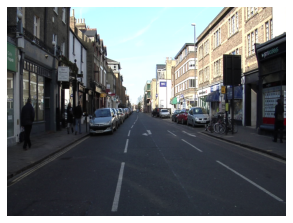

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize = (5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

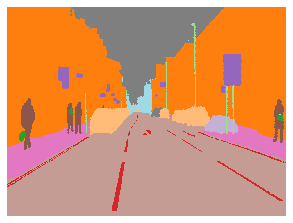

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize = (5,5) , alpha = 1)

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

Data

In [ ]:
srcsize = np.array(mask.shape[1:])
size = srcsize//2
free = gpu_mem_get_free_no_cache()
if free > 8200:bs =8
else:          bs = 4
print('using bs', bs , free , 'memory free')

using bs 8 15068 memory free


In [ ]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn , classes = codes))

In [ ]:
data = (src.transform(get_transforms() , size = size , tfm_y = True)
       .databunch(bs = bs)
       .normalize(imagenet_stats))

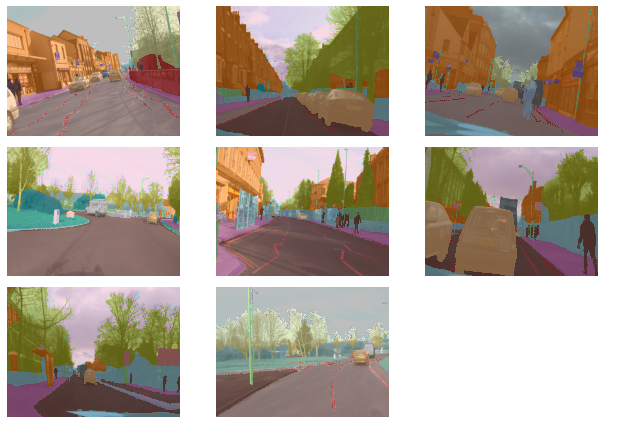

In [ ]:
data.show_batch(rows = 3 , figsize = (9,6))

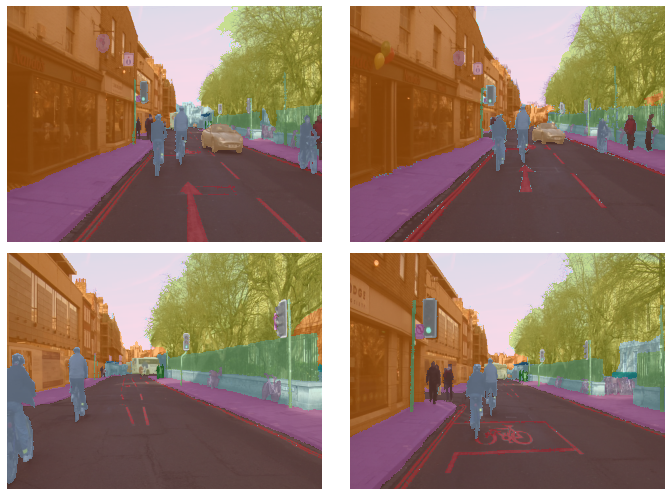

In [ ]:
data.show_batch( 2 , figsize = (10,7) ,ds_type=DatasetType.Valid)

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics = acc_camvid

In [ ]:
learn = unet_learner(data , models.resnet34 , metrics = metrics , wd = 1e-02)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


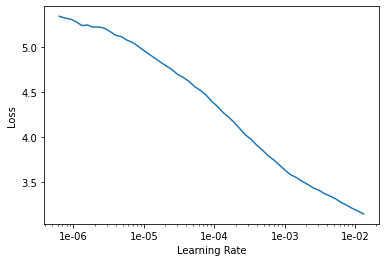

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-03

In [ ]:
learn.fit_one_cycle(4 , slice(lr) , pct_start = 0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.444717,0.415089,0.887748,01:25
1,0.474768,0.448205,0.881241,01:25
2,0.574286,0.517562,0.870808,01:25
3,0.530688,0.396812,0.888428,01:24


In [ ]:
learn.save('stage-1-res34')

In [ ]:
learn.unfreeze()

In [ ]:
learn.freeze()

In [ ]:
learn.load('stage-1-res34')

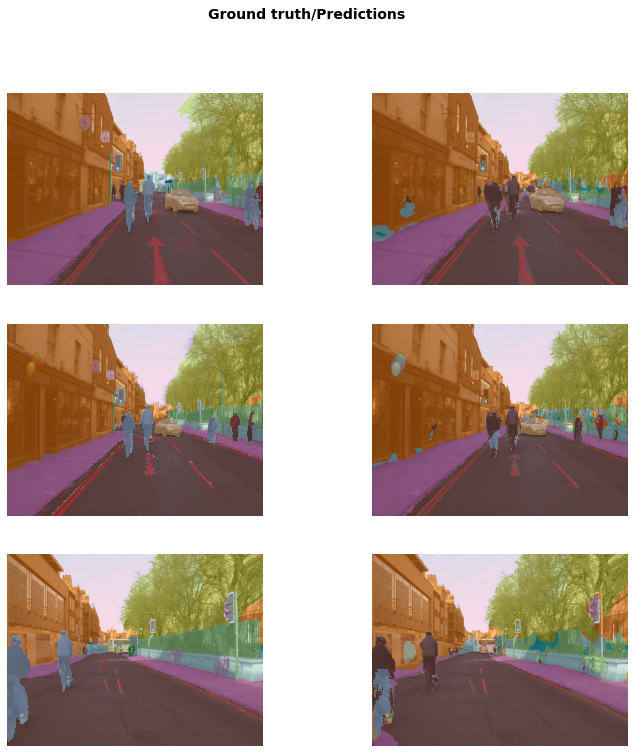

In [ ]:
learn.show_results(rows = 3 , figsize =(12 ,12))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400 , lr/4)

In [ ]:
learn.fit_one_cycle(6 , lrs , pct_start = 0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.412645,0.340265,0.906206,01:27
1,0.386490,0.323397,0.908006,01:28
2,0.372580,0.341075,0.908680,01:28
3,0.360405,0.315747,0.909186,01:28
4,0.339890,0.328536,0.907042,01:28
5,0.305568,0.276742,0.921300,01:28


In [ ]:
learn.save('stage-2')